# <div align="center">Lab 6 - Feature Selection Analysis </div>
## <div align="center"> Elder de Sousa Whalen </div>
## <div align="right"> 10.16.2020 </div>


### Overview
This lab has the purpose of comparing four different models in regards to feature selection. The models used are: Logistic regression including all features, used as the base model; Logistic regression with stepwise selection based on p-values; Random forest based on principal compnent analysis feature selection; Random Forest based on feature importance.

Logistic regression is a model that uses features to predict the output of a categorical variable.

Random forest is an ensemble learning technique that consists of a collection of a number of decision trees. It outputs the class that is the mode of the classes for a categorical target variable.

For this lab, Random forest will be used in combination with two different methods: feature importance and principal component analysis (PCA).

Gini importance is a feature selection based on the random forest classifier that gives a score based on importance to each feature.

PCA is a technique used to reduce the dimension of datasets, creating new variables that is a combination of the orignal variables while still being able to explain a great portion of the variance within the dataset.

The performance measure used to compare the models will be the [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) imported from sklearn.metrics and a comparison of the ROC/AUC curve between all models.

### Data
The caravan data set used in this lab contains information on customers of an insurance company. It contains 86 features (variables). The data was collected to attempt to answer if it's possible to predict who would be interested in buying a carvan insurance policy with the target variable being CARAVAN.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
%matplotlib inline

In [4]:
# Load the caravan dataset
url = 'https://raw.githubusercontent.com/WillKoehrsen/feature-selector/master/data/caravan-insurance-challenge.csv'

df = pd.read_csv(url)
df.head()

,ORIGIN,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,...,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,train,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,...,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,train,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,train,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,train,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,train,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,...,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [5]:
all_vars = df.drop(['ORIGIN'], axis=1)
#Group only the input variables 
x_vars = all_vars.drop(['CARAVAN'], axis=1)
#Get the target variable
y = df['CARAVAN']

print(y[0:5])
x_vars.head()

0    0
1    0
2    0
3    0
4    0
Name: CARAVAN, dtype: int64


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,...,PWALAND,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,...,0,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,...,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,...,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### Exploratory Data Analysis

In [6]:
# Check for missing values
missing = np.isnan(all_vars.values).any()
if ( missing == False):
    print('No missing values')
else:
    print('Oh uh. There are missing values!')

No missing values


In [7]:
# Summary of the input variables
x_vars.describe()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,...,PWALAND,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
count,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,...,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.00000,9822.000000,9822.000000
mean,24.253207,1.108735,2.677561,2.996437,5.779067,0.700672,4.637650,1.050092,3.262981,6.188964,0.873142,2.286602,1.887294,3.237324,4.302891,1.484525,3.307269,4.592038,1.898799,0.403278,0.545714,2.877113,2.226532,2.291183,1.650682,1.595093,2.204744,3.742211,1.068214,4.187742,4.819487,6.022501,1.335980,1.956730,6.254327,2.750662,2.577072,3.505498,2.739462,0.808491,...,0.073712,2.956424,0.054877,0.170841,0.008858,0.019344,0.093565,0.011505,0.215027,0.202301,0.011505,0.018733,0.023315,1.849420,0.001629,0.015272,0.025351,0.016697,0.045408,0.400020,0.014050,0.021279,0.557218,0.011098,0.040216,0.002240,0.011403,0.034413,0.005192,0.071065,0.079821,0.004582,0.007941,0.004276,0.574018,0.000916,0.005091,0.03146,0.008450,0.013846
std,12.918058,0.412101,0.780701,0.804660,2.874148,1.015107,1.721212,1.011156,1.606287,1.896070,0.961955,1.710674,1.779238,1.609139,1.984152,1.645968,1.723377,2.279839,1.814406,0.786792,1.106349,1.846703,1.748025,1.684008,1.742410,1.321487,1.534163,1.944900,1.298229,3.093127,3.093541,1.543980,1.213627,1.596842,2.000374,2.002960,2.073125,1.871365,1.950625,1.173771,...,0.507818,2.921736,0.566108,0.888518,0.237556,0.200885,0.604350,0.215408,0.810899,0.910574,0.188699,0.213712,0.375350,1.881271,0.057058,0.244210,0.157198,0.211487,0.396983,0.492001,0.126058,0.144319,0.608575,0.129928,0.223622,0.068402,0.116251,0.249706,0.109954,0.267432,0.384431,0.067535,0.088764,0.071224,0.561255,0.030258,0.077996,0.20907,0.092647,0.117728
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,10.000000,1.000000,2.000000,2.000000,3.000000,0.000000,4.000000,0.000000,2.000000,5.000000,0.000000,1.000000,0.000000,2.000000,3.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1

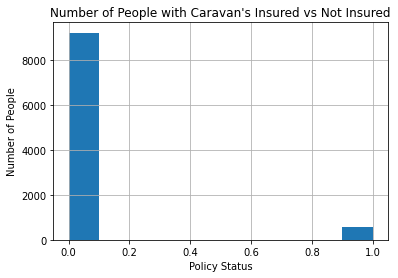

In [8]:
# Histogram of the target variable
y.hist()

# Set the title and labels
plt.xlabel("Policy Status")
plt.ylabel("Number of People")
plt.title("Number of People with Caravan's Insured vs Not Insured")

# show the plot
plt.show()

The histogram above shows imbalance in the dataset with respect to the target variable. Should the data be balanced before attempting to create any model?

In [9]:
#Attempt to capture only the highly correlated features ( > 0.6)
#https://stackoverflow.com/questions/26463714/pandas-get-combination-of-columns-where-correlation-is-high
corr_matrix = x_vars.corr().abs()

indices = np.where(corr_matrix > 0.6)
indices = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
len(indices)
print(indices)


[('MOSTYPE', 'MOSHOOFD'), ('MGEMOMV', 'MFALLEEN'), ('MGEMOMV', 'MFWEKIND'), ('MGODPR', 'MGODGE'), ('MRELGE', 'MRELOV'), ('MRELGE', 'MFALLEEN'), ('MRELOV', 'MFALLEEN'), ('MRELOV', 'MAUT0'), ('MFALLEEN', 'MFWEKIND'), ('MOPLHOOG', 'MOPLLAAG'), ('MOPLHOOG', 'MSKA'), ('MOPLMIDD', 'MOPLLAAG'), ('MOPLLAAG', 'MSKA'), ('MOPLLAAG', 'MSKC'), ('MBERHOOG', 'MSKA'), ('MBERHOOG', 'MZFONDS'), ('MBERHOOG', 'MZPART'), ('MBERARBG', 'MSKC'), ('MHHUUR', 'MHKOOP'), ('MAUT1', 'MAUT0'), ('MZFONDS', 'MZPART'), ('MINKM30', 'MINKGEM'), ('MINK7512', 'MINKGEM'), ('PWAPART', 'AWAPART'), ('PWABEDR', 'AWABEDR'), ('PWALAND', 'AWALAND'), ('PPERSAUT', 'APERSAUT'), ('PBESAUT', 'ABESAUT'), ('PMOTSCO', 'AMOTSCO'), ('PVRAAUT', 'AVRAAUT'), ('PAANHANG', 'AAANHANG'), ('PTRACTOR', 'ATRACTOR'), ('PWERKT', 'AWERKT'), ('PBROM', 'ABROM'), ('PLEVEN', 'ALEVEN'), ('PPERSONG', 'APERSONG'), ('PGEZONG', 'AGEZONG'), ('PWAOREG', 'AWAOREG'), ('PBRAND', 'ABRAND'), ('PZEILPL', 'AZEILPL'), ('PPLEZIER', 'APLEZIER'), ('PFIETS', 'AFIETS'), ('PINB

The code above shows that there are 44 pairs of features with a correlation greater than |0.6|. This is an indication of the presence of collinearity in the dataset.

### Models

In [10]:
#Firt split the data 70% train and 30% test

X_train, X_test, y_train, y_test = train_test_split(x_vars, y, test_size=0.3, random_state=0)

In [11]:
## BALANCED DATA SET using SMOTE (COMMENT this whole cell to used imbalanced data)
from imblearn.over_sampling import SMOTE
#
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#### Logistic regression using all features

In [12]:
# Create logist regression object
logreg = linear_model.LogisticRegression(max_iter=10000)

# Train the model using the training sets
logreg.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = logreg.predict(X_test)

#Print the accuracy score of the logist model
print('Logistic Regression Accuracy: {:.2f}'.format(logreg.score(X_test, y_test)))


Logistic Regression Accuracy: 0.92


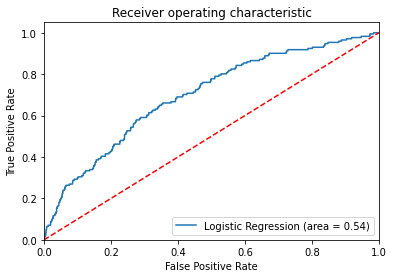

In [13]:
# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Logistic Regression with stepwise based on p-values<br>

In [14]:
#https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn/24447#24447

import statsmodels.api as sm

X = x_vars


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
#            best_feature = new_pval.argmin()
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  PPERSAUT                       with p-value 2.14684e-42
Add  MKOOPKLA                       with p-value 1.36739e-21
Add  PWAPART                        with p-value 3.66711e-15
Add  APLEZIER                       with p-value 8.20766e-15
Add  MOPLHOOG                       with p-value 4.25236e-06
Add  PBRAND                         with p-value 3.92829e-06
Add  MBERBOER                       with p-value 8.31838e-06
Add  MRELGE                         with p-value 1.41977e-05
Add  PWALAND                        with p-value 0.000361295
Add  ABRAND                         with p-value 0.000937601
Add  AZEILPL                        with p-value 0.00153041
Add  MINK123M                       with p-value 0.00152554
Add  PBYSTAND                       with p-value 0.00243579
Add  PGEZONG                        with p-value 0.00485648
Add  AGEZONG                        with p-value 0.00450709
Add  MHHUUR                         with p-value 0.00630075
resulting features:
['PPERSAUT

In [15]:
new_xvars = x_vars[['PPERSAUT', 'MKOOPKLA', 'PWAPART', 'APLEZIER', 'MOPLHOOG', 'PBRAND', 'MBERBOER', 'MRELGE', 'PWALAND', 'ABRAND', 'AZEILPL', 'MINK123M', 'PBYSTAND', 'PGEZONG', 'AGEZONG', 'MHHUUR']]
new_xvars.head()

,PPERSAUT,MKOOPKLA,PWAPART,APLEZIER,MOPLHOOG,PBRAND,MBERBOER,MRELGE,PWALAND,ABRAND,AZEILPL,MINK123M,PBYSTAND,PGEZONG,AGEZONG,MHHUUR
0,6,3,0,0,1,5,1,7,0,1,0,0,0,0,0,1
1,0,4,2,0,0,2,0,6,0,1,0,0,0,0,0,2
2,6,4,2,0,0,2,0,3,0,1,0,0,0,0,0,7
3,6,4,0,0,3,2,0,5,0,1,0,0,0,0,0,5
4,0,3,0,0,5,6,4,7,0,1,0,0,0,0,0,4


In [16]:
# Split the data 70% train and 30% test

#X_train, X_test, y_train, y_test = train_test_split(new_xvars, y, test_size=0.3, random_state=0)

In [17]:
# Create logist regression object
logreg_pval = linear_model.LogisticRegression(max_iter=10000)

# Train the model using the training sets
logreg_pval.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = logreg_pval.predict(X_test)

#Print the accuracy score of the logist model
print('Logistic Regression Accuracy: {:.2f}'.format(logreg_pval.score(X_test, y_test)))

Logistic Regression Accuracy: 0.92


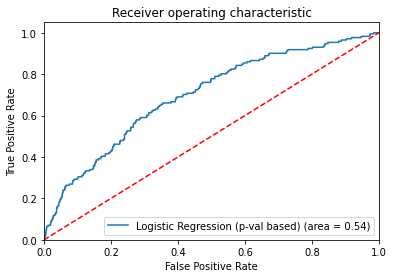

In [18]:
# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg_pval.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg_pval.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (p-val based) (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Random Forest based on Principal component analysis 

In [19]:
from sklearn.preprocessing import StandardScaler

# standardize the data 
X_std = StandardScaler().fit_transform(x_vars)
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00010182 -0.04033167 -0.0065945  ... -0.0255354  -0.01633792
  -0.04375385]
 [-0.04033167  1.00010182 -0.00431565 ... -0.01252764  0.0319394
  -0.005852  ]
 [-0.0065945  -0.00431565  1.00010182 ...  0.01848839  0.01092878
   0.03085877]
 ...
 [-0.0255354  -0.01252764  0.01848839 ...  1.00010182  0.00204416
   0.00712214]
 [-0.01633792  0.0319394   0.01092878 ...  0.00204416  1.00010182
   0.01727922]
 [-0.04375385 -0.005852    0.03085877 ...  0.00712214  0.01727922
   1.00010182]]


In [20]:
#Perform eigendecomposition on covariance matrix
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-1.80741073e-01  1.90012238e-01 -1.08200120e-02 ... -1.19823729e-02
   1.86481597e-03 -3.99575753e-04]
 [ 6.86446049e-05 -9.97766755e-03  1.42353206e-02 ... -5.62264287e-03
   1.64017734e-03 -1.88420999e-03]
 [ 1.21471618e-01  2.78081107e-01  9.89312897e-02 ...  1.32823262e-03
  -4.33591381e-03 -1.66503718e-03]
 ...
 [ 1.26127757e-02 -1.12937278e-02  2.14048183e-02 ...  9.27489842e-03
  -2.15410748e-02 -4.32546502e-03]
 [ 1.32624344e-02 -5.62562226e-03 -1.97657957e-02 ...  1.93069813e-03
  -1.94621753e-03 -5.83645630e-03]
 [ 2.36962778e-02  1.36883444e-02 -4.79283762e-02 ...  4.76677274e-02
   1.50691498e-02 -3.00046503e-02]]

Eigenvalues 
[9.38114298e+00 4.90789884e+00 3.98336652e+00 3.34322942e+00
 2.92824840e+00 2.64384083e+00 2.26219960e+00 2.23659410e+00
 2.14010672e+00 2.10857567e+00 2.00996208e+00 1.95746407e+00
 1.91389055e+00 1.90310544e+00 1.86888982e+00 1.84630241e+00
 1.79586996e+00 1.81596659e+00 1.72663381e+00 1.68813177e+00
 1.64806302e+00 1.62031830e+00 

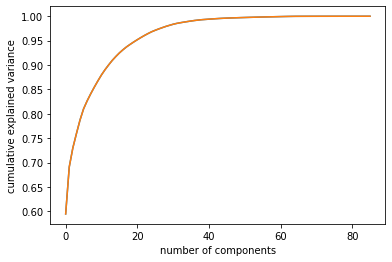

In [21]:
pca = PCA().fit(all_vars)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [22]:
pca = PCA(0.90).fit(all_vars)
pca.n_components_

13

From the results above, using PCA we were able to reduce the predicting variables from 85 to 13 and still be able to explain about 90% of the variance.

In [23]:
#https://towardsdatascience.com/machine-learning-step-by-step-6fbde95c455a
# Split the data 70% train and 30% test

X_train_std, X_test_std, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=0)

## Balance Standardized data (COMMENT the next line to used imbalanced data)
X_train_std, y_train = smt.fit_sample(X_train_std, y_train)

# Reduce the number of features from 85 to 13 in the X_train_std and X_test_std data
pca = PCA(n_components=13)
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [24]:
# Fit train data to Random Forest Model

from sklearn.ensemble import RandomForestClassifier

rfc_pca = RandomForestClassifier(n_estimators=1000, random_state=0)
rfc_pca.fit(X_train_pca, y_train)

y_pred = rfc_pca.predict(X_test_pca)
accuracy_score(y_test, y_pred)

0.8812351543942993

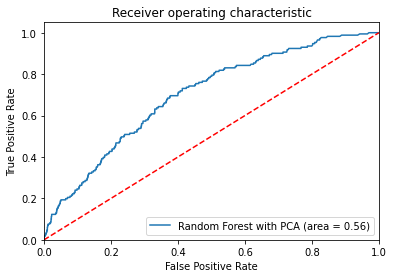

In [26]:
# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rfc_pca_roc_auc = roc_auc_score(y_test, rfc_pca.predict(X_test_pca))
fpr, tpr, thresholds = roc_curve(y_test, rfc_pca.predict_proba(X_test_pca)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest with PCA (area = %0.2f)' % rfc_pca_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Random Forest based on feature importance feature selection

In [27]:
#Firt split the data 70% train and 30% test

X_train, X_test, y_train, y_test = train_test_split(x_vars, y, test_size=0.3, random_state=0)

## Balance data (COMMENT the next line to used imbalanced data)
X_train, y_train = smt.fit_sample(X_train, y_train)

# Create a list of feature names
feat_labels = x_vars.columns

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [28]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0)

# Train the classifier
clf.fit(X_train, y_train)


# Print the name and gini importance of each feature
for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)

('MOSTYPE', 0.02865038332318664)
('MAANTHUI', 0.0033211452415673696)
('MGEMOMV', 0.012928464884830453)
('MGEMLEEF', 0.019028706469423753)
('MOSHOOFD', 0.02063192019850816)
('MGODRK', 0.010666550317954361)
('MGODPR', 0.01731677608579397)
('MGODOV', 0.01268806601556326)
('MGODGE', 0.027229081866685836)
('MRELGE', 0.01780975753340706)
('MRELSA', 0.016583442532638305)
('MRELOV', 0.022920109373416455)
('MFALLEEN', 0.018134675165821578)
('MFGEKIND', 0.021933230617418573)
('MFWEKIND', 0.01835423454564352)
('MOPLHOOG', 0.013074929096487022)
('MOPLMIDD', 0.021501583300909344)
('MOPLLAAG', 0.026954535029562014)
('MBERHOOG', 0.014257147741434434)
('MBERZELF', 0.006684012503037637)
('MBERBOER', 0.02279056995066769)
('MBERMIDD', 0.015151499035594066)
('MBERARBG', 0.019721911917094985)
('MBERARBO', 0.018982579547866505)
('MSKA', 0.012482902061965449)
('MSKB1', 0.015155039073476342)
('MSKB2', 0.02171831712902182)
('MSKC', 0.020517495720469653)
('MSKD', 0.013167439318364362)
('MHHUUR', 0.0222775957486

In [29]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.02
sfm = SelectFromModel(clf, threshold=0.02)

# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=1000, n_jobs=None,
                                                 oob_score=False

In [30]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

MOSTYPE
MOSHOOFD
MGODGE
MRELOV
MFGEKIND
MOPLMIDD
MOPLLAAG
MBERBOER
MSKB2
MSKC
MHHUUR
MAUT0
MINKM30
MINK3045
PPERSAUT
PBRAND
APERSAUT


In [31]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [32]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [33]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (2 Features) Model
accuracy_score(y_test, y_important_pred)

0.8954869358669834

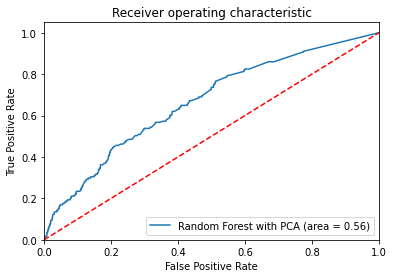

In [34]:
# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rfc_feat_roc_auc = roc_auc_score(y_test, clf_important.predict(X_important_test))
fpr, tpr, thresholds = roc_curve(y_test, clf_important.predict_proba(X_important_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest with PCA (area = %0.2f)' % rfc_feat_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Results comparison table - Imbalanced data
|   | LogReg_ALL  | LogReg_Step  | RFC_PCA  | RFC_Feature  |
|---|---|---|---|---|
| N Features  | 85  | 16  | 13  | 10  |
| AUC  | 51  | 50  | 51  | 51  |
| Accuracy  | 0.94  | 0.94  | 0.934  | 0.925  |

### Results comparison table - Balanced data (SMOTE)
|   | LogReg_ALL  | LogReg_Step  | RFC_PCA  | RFC_Feature  |
|---|---|---|---|---|
| N Features  | 85  | 16  | 13  | 17  |
| AUC  | 54  | 54  | 56  | 56  |
| Accuracy  | 0.92  | 0.92  | 0.880  | 0.895  |

### Conclusions

From the results shown on the two tables above we can observe that we can achieve a very high accuracy when using a much smaller number of features. Whether using p-values, PCA or feature importance, all models showed similar accuracy and AUC values. But the AUC values were equal or very close to 0.5 which indicates that the models are not able to discriminate the target variable. What happens if the data is balanced?

Using the SMOTE method to balance the Caravan data set, slightly different results were obtained. The accuracy value for all models tested decreased but the AUC values increased, improving, even if just a little, the ability of the models to discriminate the target variable.

Still, given that all values reported in the AUC are near 0.5, none of this models have a good predictive power.

### References
1. https://www.kaggle.com/uciml/caravan-insurance-challenge/home 
2. https://machinelearningmastery.com/feature-selection-machine-learning-python/
3. https://districtdatalabs.silvrback.com/principal-component-analysis-with-python
4. https://chrisalbon.com/machine_learning/trees_and_forests/feature_selection_using_random_forest/
5. https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2264-5
6. https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
7. https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn/24447#24447
8. https://towardsdatascience.com/machine-learning-step-by-step-6fbde95c455a
9. https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3